<a href="https://colab.research.google.com/github/TrynowPht/TPMachineLearning/blob/master/TP_MachinLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Integrantes:
*   Piero Herrera
*   Camilo Silva
*   Diego Urruria


## **Introducción**

Uno de los muchos problemas que presentan los bancos está relacionado con otorgar préstamos a sus clientes. La entidad debe revisar toda información crediticia del cliente que solicita un préstamo. Además tiene que tener en cuenta muchos otros factores: si tiene familia, trabajo estable, ingresos, etc. El problema presente a resolver es el de entrenar un modelo de clasificación, con data histórica del banco, para poder apoyar la decisión de desembolsar un préstamo. Existen muchos modelos de clasificación, tanto para binarias como multiclases: KNN, Naive Bayes, Redes Bayesianas, etc., los cuales han sido aplicados en áreas como la detección de spam y clasificación de imágenes.

Nuestra motivación es encontrar el mejor modelo que permita entrenar la data histórica del banco y sirva de apoyo para tomar la decisión de otorgar o no un prestamo al cliente.

**¿Qué es clasificación en Machine Learning?**

Es una subcategoría del aprendizaje supervisado que tiene como objetivo definir las etiquetas de una clase arbitraria de nuevas instancias, todo esto basándose en información pasada.

Dada la situación del problema propuesto, la clasificación que se realizará es binaria. Esto debido a que solo existen dos etiquetas que colocar: **0** si el cliente cumplió los pagos y **1** si la persona cayó en mora.

In [1]:
#@title Importación de Librerías
import pandas as pd
import missingno as msno
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from ipywidgets import FileUpload
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from keras.models import Sequential
from keras.layers import Dense, LSTM
from numpy import  newaxis
%matplotlib inline

### Lectura de la Data

In [2]:
DataSet = FileUpload()
DataSet

FileUpload(value={}, description='Upload')

In [3]:
with open('datos_banco.csv', "wb") as fp:
    fp.write(DataSet.data[0])
df = pd.read_csv("datos_banco.csv", engine='python')
df.head(5)

,idPrestamo,target,monthly_debt_capacity,var_employment_time_in_months,approved_amount,approved_term,approved_interest_amount,var_net_income,person_gender,credit_history_marital_status,var_max_sbs_qual_12m,person_degree_type_desc,default_request_term,default_request_amount
0,LIBDISP9832897855,1,252.39,9.0,"1,200",6,289.11,1140.125000,MALE,C,NORMAL,Secundaria,1,0
1,LIBDISP9021501745,1,244.57,50.0,"2,200",12,696.15,1061.375000,FEMALE,S,NORMAL,Secundaria,0,0
2,LIBDISP4057314971,0,491.5,64.0,"1,000",3,84.99,2082.196667,FEMALE,S,NORMAL,Secundaria,0,0
3,LIBDISP8375185888,0,848.65,77.0,"1,500",6,221.53,3422.423333,MALE,S,NORMAL,Universitaria,0,0
4,LIBDISP9694463037,0,470.52,82.0,"1,000",3,91.34,1882.090000,FEMALE,S,NORMAL,Universitaria,1,0


La data a utilizar es un dataframe, es decir, un conjunto de datos organizados en estructuras rectangulares en forma de tabla o matriz, el cual contiene distintos tipos de datos y están organizados por columnas con su atributo correspondiente. Considerando esto podemos decir que la data es de tipo estructurada.

## 1. Análisis Exploratorio

### 1.1 Cantidad de variables y atributos

In [4]:
print('Cantidad de instancias:',df.shape[0])
print('Cantidad de atributos:',df.shape[1])

Cantidad de instancias: 1719
Cantidad de atributos: 14


### 1.2 Valores nulos

En el siguiente gráfico podemos ver la existencia de valores nulos a lo largo de cada instancia, como resultado podemos observar que solo el atributo ***var_employment_time_in_month*** contiene valores nulos.

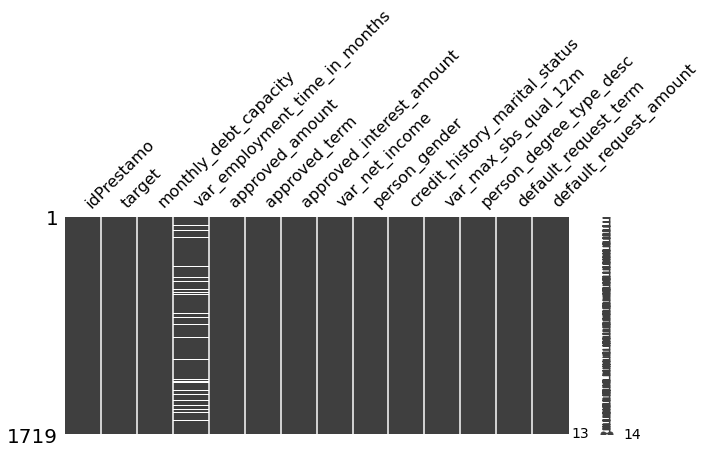

In [5]:
msno.matrix(df, figsize=(10,4));

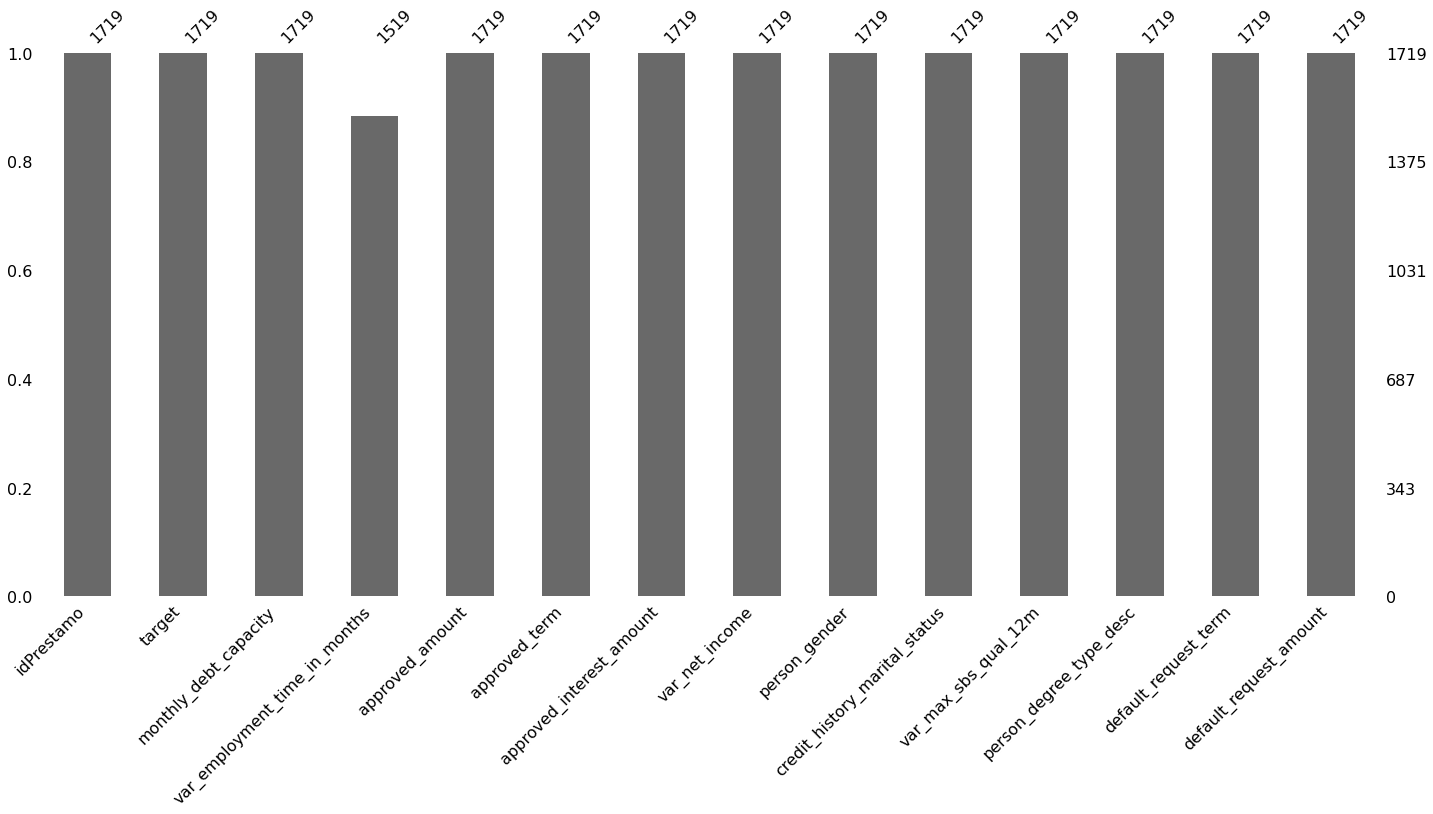

In [6]:
msno.bar(df) 

Obtenemos la cantidad exacta de valores nulos en el dataframe, podemos concluir que la proporción de datos nulos es bastante ***reducida***.

In [7]:
df.isna().sum()

idPrestamo                         0
target                             0
monthly_debt_capacity              0
var_employment_time_in_months    200
approved_amount                    0
approved_term                      0
approved_interest_amount           0
var_net_income                     0
person_gender                      0
credit_history_marital_status      0
var_max_sbs_qual_12m               0
person_degree_type_desc            0
default_request_term               0
default_request_amount             0
dtype: int64

### 1.3 Atributos

A continuación, podemos observar la lista de atributos del dataset, junto con su tipo de dato. Además, podemos determinar el conjunto de atributos que podrían aportar valor significativo a nuestro modelo y aquellos que no.



In [8]:
df.dtypes

idPrestamo                        object
target                             int64
monthly_debt_capacity             object
var_employment_time_in_months    float64
approved_amount                   object
approved_term                      int64
approved_interest_amount          object
var_net_income                   float64
person_gender                     object
credit_history_marital_status     object
var_max_sbs_qual_12m              object
person_degree_type_desc           object
default_request_term               int64
default_request_amount             int64
dtype: object

Podemos observar además que variables con tipos de dato que no corresponden al valor que se muestra en el dataframe. Tal es el caso de **monthly_debt_capacity**, **approved_amount** y **approved_interest_amount**

In [9]:
df.describe()

,target,var_employment_time_in_months,approved_term,var_net_income,default_request_term,default_request_amount
count,1719.000000,1519.000000,1719.000000,1719.000000,1719.000000,1719.0
mean,0.295521,33.979592,6.464805,2693.545884,0.507853,0.0
std,0.456409,26.889423,3.009842,1825.694773,0.500084,0.0
min,0.000000,-1.000000,1.000000,0.000000,0.000000,0.0
25%,0.000000,11.000000,6.000000,1750.000000,0.000000,0.0
50%,0.000000,26.000000,6.000000,2373.758333,1.000000,0.0
75%,1.000000,61.000000,6.000000,3075.133333,1.000000,0.0
max,1.000000,87.000000,12.000000,28587.000000,1.000000,0.0


### 1.4. Atributos categóricos

El dataset contiene 3 atributos categóricos (***credit_history_marital_status***	***var_max_sbs_qual_12m*** y	***person_degree_type_desc***). Haremos un análisis exploratorio en ellos con la finalidad de descubrir particularidades.

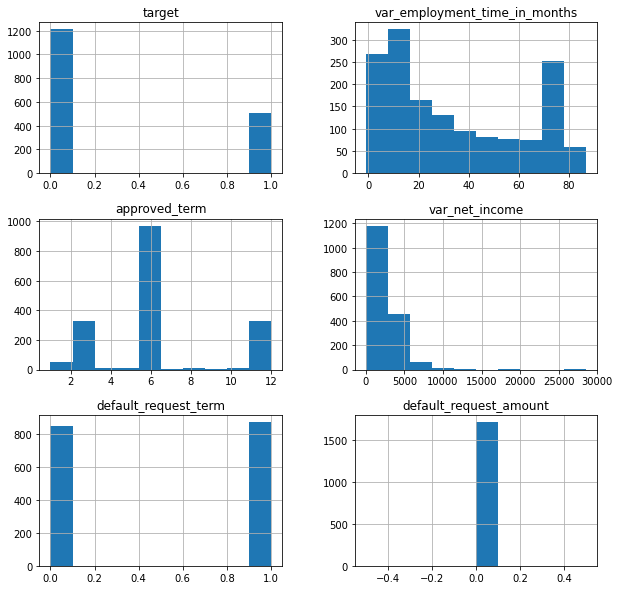

In [10]:
df.hist(figsize=(10,10));

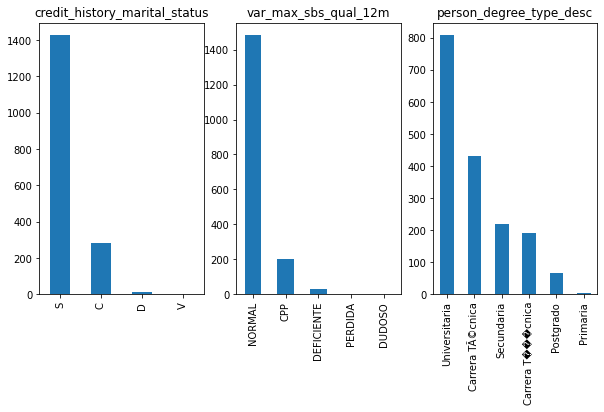

In [11]:
atrib_cat = ['credit_history_marital_status', 'var_max_sbs_qual_12m', 'person_degree_type_desc']

fig, ax = plt.subplots(1, len(atrib_cat), figsize=(10,5))
for i, categorical_feature in enumerate(df[atrib_cat]):
    df[categorical_feature].value_counts().plot(kind='bar', ax=ax[i]).set_title(categorical_feature)
fig.show()

En el gráfico de barras anterior, podemos visualizar que la *categoría carrera* técnica del atributo ***person_degree_type_desc*** se repite varias veces con nombres similares, por lo que deberemos reemplazar en una sola y unir los registro que presente dicha categoría.

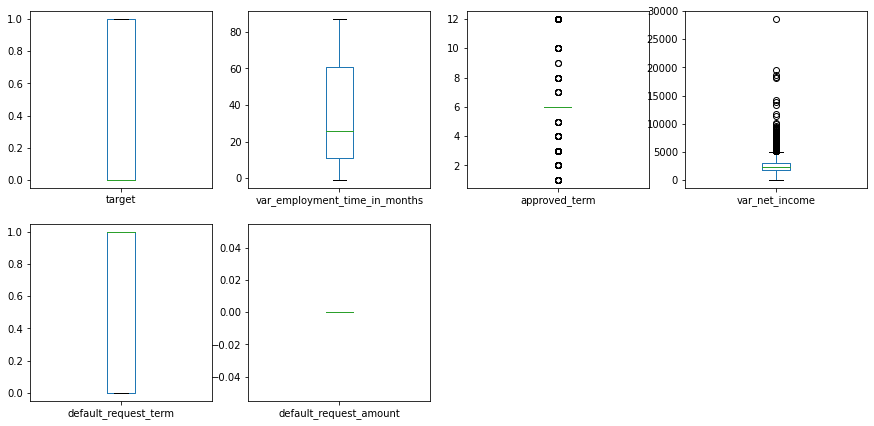

In [12]:
df.plot(kind='box', subplots = True, layout=(4,4), figsize=(15,15));

Con estos gráficos de cajas podemos analizar los outlaiers respecto a cada atributo y si es necesario ralizar alguna eliminación de registros

### 1.5 Atributo Clase
 
En el siguiente gráfico podemos observar la proporción de instancias del atributo clase del dataset (***target***)

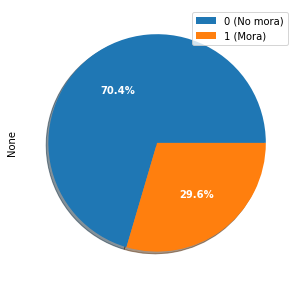

In [13]:
df.groupby(['target']).size().plot(kind='pie', legend=True, figsize = (5,5), labels=['0 (No mora)', '1 (Mora)'], autopct='%1.1f%%', shadow=True, textprops={'color':"w", 'weight':"bold"});

### 1.6. Registros duplicados
Para el análisis de data duplicada utilizaremos **duplicated().sum()** el cual nos permitirá identificar si existen registros que tienen los mismo atributos que otro dentro del mismo dataframe.


In [14]:
df.duplicated().sum()

0

## 2. Tratamiento de Datos




### 2.1. Cast de Atributos

Como podemos ver, muchas de las *variables* continen *valores numéricos*; ***sin embargo***, algunas de ellas (***monthly_deb_capacity***, ***approved_amounts***, ***approved_interest_amount***) no son reconocidas como tal en el entorno de ejecución. Por ello, se hará un *cast* de dichos valores

In [15]:
atribs_obj = ['monthly_debt_capacity', 'approved_amount', 'approved_interest_amount']

for atrib in atribs_obj:
  df[atrib] = df[atrib].str.replace(',', '', regex=True)
  df[atrib] = pd.to_numeric(df[atrib], downcast="float")

In [16]:
df.dtypes

idPrestamo                        object
target                             int64
monthly_debt_capacity            float32
var_employment_time_in_months    float64
approved_amount                  float32
approved_term                      int64
approved_interest_amount         float32
var_net_income                   float64
person_gender                     object
credit_history_marital_status     object
var_max_sbs_qual_12m              object
person_degree_type_desc           object
default_request_term               int64
default_request_amount             int64
dtype: object

Como podemos observar, los tipos de datos han sido convertidos a float para su manejabilidad

### 2.2. Descartando atributos

Luego del análisis de variables, podemos descartar algunas que no aportarían valor a nuestro modelo. Estas son:

1.   **idPrestamo**: Identificador de Préstamo
2.   **person_gender**: Género de la persona que solicito el préstamo
3. **default_request_amount**: Si escogio el monto de dinero ofrecido (según muestra el histograma anterior, todos los valores son 0)


In [17]:
df = df.drop(["idPrestamo", "person_gender", "default_request_amount"], axis=1)

In [18]:
df.columns.shape[0]

11

**df.columns.shape[0]** nos indica la cantidad de atributos actuales. Ya que se eliminaron tres columnas del dataframe obtenemos como resultado 11 (anteriormente 14 columnas)

### 2.3. Corrección de Carrera Ténica
Tomando en referencia el análisis realizado en la sección 1.4. de atributos categóricos, debemos de realizar la corrección en cuestión

In [19]:
df["person_degree_type_desc"] = np.where(df["person_degree_type_desc"].str.contains('Carrera'), 'Carrera Tecnica', df["person_degree_type_desc"])

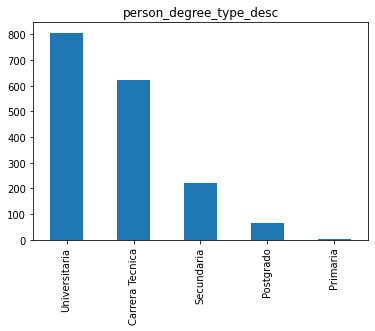

In [20]:
df['person_degree_type_desc'].value_counts().plot(kind='bar').set_title('person_degree_type_desc')
plt.show()

Podemos obserbar que ahora sí solo existe una sola categoría Carrera Técnica que engobla las categorías con errores

### 2.4. Conversión de Atributos categóricos

Para convertir los atributos categóricos utilizaremos ***One Hot Encoding***, al ser reemplazados con este algoritmo, serán eliminados del dataset.

In [21]:
atribs_prefix = ['chm', 'vms', 'pdt']

# One Hot Encoding
for prefixs, atrib in zip(atribs_prefix, atrib_cat):
  ohe = pd.get_dummies(df[atrib], prefix=prefixs)
  df = pd.concat([df, ohe], axis = 1)

# Eliminando atributos
for atrib in atrib_cat:
  df = df.drop(columns=[atrib])

df.head(5)

,target,monthly_debt_capacity,var_employment_time_in_months,approved_amount,approved_term,approved_interest_amount,var_net_income,default_request_term,chm_C,chm_D,chm_S,chm_V,vms_CPP,vms_DEFICIENTE,vms_DUDOSO,vms_NORMAL,vms_PERDIDA,pdt_Carrera Tecnica,pdt_Postgrado,pdt_Primaria,pdt_Secundaria,pdt_Universitaria
0,1,252.389999,9.0,1200.0,6,289.109985,1140.125000,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0
1,1,244.570007,50.0,2200.0,12,696.150024,1061.375000,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
2,0,491.500000,64.0,1000.0,3,84.989998,2082.196667,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,0,848.650024,77.0,1500.0,6,221.529999,3422.423333,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
4,0,470.519989,82.0,1000.0,3,91.339996,1882.090000,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1


In [22]:
print('Nueva cantidad de atributos:',df.shape[1])
print(df.dtypes)

Nueva cantidad de atributos: 22
target                             int64
monthly_debt_capacity            float32
var_employment_time_in_months    float64
approved_amount                  float32
approved_term                      int64
approved_interest_amount         float32
var_net_income                   float64
default_request_term               int64
chm_C                              uint8
chm_D                              uint8
chm_S                              uint8
chm_V                              uint8
vms_CPP                            uint8
vms_DEFICIENTE                     uint8
vms_DUDOSO                         uint8
vms_NORMAL                         uint8
vms_PERDIDA                        uint8
pdt_Carrera Tecnica                uint8
pdt_Postgrado                      uint8
pdt_Primaria                       uint8
pdt_Secundaria                     uint8
pdt_Universitaria                  uint8
dtype: object


Como podemos observar, la cantidad de atributos aumentan (columnas) a partir de la implementación del ***One Hot Encoding***.

### 2.5. Sustitución de valores nulos
La función sklearn.impute.SimpleImputer permite sustituir valores nulos por otros valores según varias estrategias disponibles. La estrategia a ejecutar se indica mediante el parámetro strategy.

En este caso el ***atributo var_employment_time_in_months*** tenia valores NA la estrategia es sustituir los valores nulos por el valor medio de las características

In [23]:
from sklearn.impute import SimpleImputer
si = SimpleImputer()

df["var_employment_time_in_months"] = si.fit_transform(df["var_employment_time_in_months"].values.reshape(-1, 1))

df.head(11)
df.describe()

,target,monthly_debt_capacity,var_employment_time_in_months,approved_amount,approved_term,approved_interest_amount,var_net_income,default_request_term,chm_C,chm_D,chm_S,chm_V,vms_CPP,vms_DEFICIENTE,vms_DUDOSO,vms_NORMAL,vms_PERDIDA,pdt_Carrera Tecnica,pdt_Postgrado,pdt_Primaria,pdt_Secundaria,pdt_Universitaria
count,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000
mean,0.295521,584.639282,33.979592,2136.998291,6.464805,407.184509,2693.545884,0.507853,0.162885,0.007563,0.828970,0.000582,0.117510,0.018034,0.000582,0.861547,0.002327,0.363002,0.037813,0.001745,0.127981,0.469459
std,0.456409,459.958984,25.275851,1504.947632,3.009842,407.703125,1825.694773,0.500084,0.369369,0.086659,0.376644,0.024119,0.322121,0.133112,0.024119,0.345475,0.048196,0.481005,0.190798,0.041751,0.334166,0.499212
min,0.000000,-158.750000,-1.000000,500.000000,1.000000,22.820000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,350.760010,12.000000,1000.000000,6.000000,152.320007,1750.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,480.739990,33.000000,1500.000000,6.000000,281.390015,2373.758333,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,660.820007,55.000000,2500.000000,6.000000,429.799988,3075.133333,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,7243.200195,87.000000,12200.000000,12.000000,2311.120117,28587.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 2.6. Outliers 
  En este caso identificamos en la variable var_net_income (salario) presentaba valores atipicos a partir del analisis del diagrama de cajas. Identificamos el valor Max a partir de los percentiles 25 y 75. Se utiliza los imputers para rellenar los valores atipicos.


1750.0 3075.1333335 5062.83333375


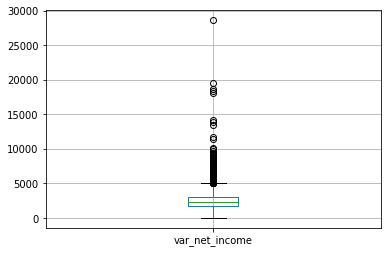

In [24]:
Q1 =  df['var_net_income'].quantile(0.25)
Q3 = df['var_net_income'].quantile(0.75)
IQR = Q3 - Q1

Max = Q3+1.5*IQR

boxplot = df.boxplot(column=['var_net_income'])

df.loc[(df['var_net_income'] > Max)] = None

print(Q1,Q3,Max)

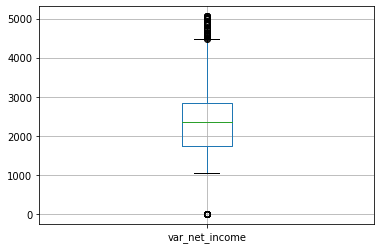

In [25]:
df['var_net_income'].describe()

df.loc[(df['var_net_income'] > Max)] = None

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')


df["var_net_income"] = imp_mean.fit_transform(df["var_net_income"].values.reshape(-1, 1))

boxplot = df.boxplot(column=['var_net_income'])
df["var_net_income"].describe()

df = df.dropna()

### 2.7 Normalización de datos

Utilizaremos la ***MinMaxScaler*** para normalizar nuestros datos para los modelos

In [26]:
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df.head(5)

,target,monthly_debt_capacity,var_employment_time_in_months,approved_amount,approved_term,approved_interest_amount,var_net_income,default_request_term,chm_C,chm_D,chm_S,chm_V,vms_CPP,vms_DEFICIENTE,vms_DUDOSO,vms_NORMAL,vms_PERDIDA,pdt_Carrera Tecnica,pdt_Postgrado,pdt_Primaria,pdt_Secundaria,pdt_Universitaria
0,1.0,0.252037,0.113636,0.064815,0.454545,0.116370,0.225366,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.247243,0.579545,0.157407,1.000000,0.294249,0.209799,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.398616,0.738636,0.046296,0.181818,0.027169,0.411583,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.617556,0.886364,0.092593,0.454545,0.086837,0.676502,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.385755,0.943182,0.046296,0.181818,0.029944,0.372028,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


### 2.8 Separación de datos en subconjuntos

Para que nuestros modelos puedan procesar los datos, los separaremos en subconjuntos, X contendrá los atributos mientras y contendrá el atributo clase

In [27]:
X = df[[x for x in df.columns if x != 'target']]
y = pd.to_numeric(df['target'], downcast="integer")

## 3. Clasificación y validación de modelos

Los modelos para la clasificación de registros serán: **KNN**, **Gaussian Naive Bayes**, **Multinomial Naive Bayes**, **SVC** y la **red neuronal LSTM**

En cada uno de estos modelos se implementará cross-validation para obtener el rendimiento promedio, mientras que los párametros se obtendrán con forme visualizemos las gráficas correspondientes.

Para el problema a resolver, como banco interesa mucho más acertar con las personas a las que no les debo desembolsar un préstamo, pues no hacerlo supondría una pérdida de dinero. Es por eso que el rendimiento de la clasificación la basaremos en ***f1 ponderado***, el cual combina precision y recall para obtener un rendimiento combinado de estas dos medidas. 

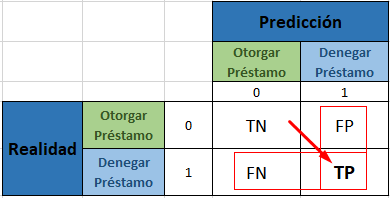

Para la graficación de las curvas de aprendizaje usamos como referencia la función ***plot_learning_curve*** la cual podemos encontrar [aquí](https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html). Esta función además nos permitirá visualizar graficamente el performance y la escalabilidad del modelo.

In [28]:
#@title Código de la funcion plot_learning_curve

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

### 3.1. Modelo Nearest Neighbors

El principio detrás este modelo es encontrar un número predefinido de muestras de entrenamiento más cercanas en distancia al nuevo punto y de esta forma la la clase a partir de ellas. El valor de ***n*** nos indica la cantidad de vecinos que tomaremos en cuenta para la clasificación y la complejidad.

Probando KNN

In [29]:
knn = KNeighborsClassifier(n_neighbors=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10,train_size = 0.5)
kfold = KFold(n_splits = 10, random_state = 10)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [30]:
knn.fit(X_train, y_train)
y_knn_predict = knn.predict(X_test)
print(classification_report(y_test, y_knn_predict))
print("Accuracy Test: ",accuracy_score(y_test, y_knn_predict))

              precision    recall  f1-score   support

           0       0.70      0.91      0.79       550
           1       0.41      0.14      0.21       253

    accuracy                           0.67       803
   macro avg       0.55      0.52      0.50       803
weighted avg       0.61      0.67      0.61       803

Accuracy Test:  0.6662515566625156


In [31]:
print("Accuracy Average  : ", cross_val_score(knn, X, y, cv=kfold, scoring = "accuracy").mean())
print("F1 Average        : ",cross_val_score(knn, X, y, cv=kfold, scoring = "f1_weighted").mean())
print("Precision Average : ",cross_val_score(knn, X, y, cv=kfold, scoring = "precision_weighted").mean())
print("Recall Average    : ",cross_val_score(knn, X, y, cv=kfold, scoring = "recall_weighted").mean())

Accuracy Average  :  0.676607142857143
F1 Average        :  0.624778777426098
Precision Average :  0.6271879595404714
Recall Average    :  0.676607142857143


Para determinar que valor de n y el tamaño de la data de entrenamiento (parámetros adecuados) , realizaremos la gráfica de **validación** y **aprendizaje**

3.1.1. Gráfica de Validación

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


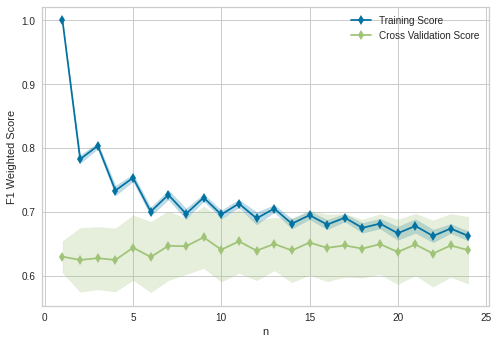

In [32]:
from yellowbrick.model_selection import ValidationCurve
param_range = np.arange(0, 25, 1)
knnVcF1w = ValidationCurve(
    KNeighborsClassifier(), param_name="n_neighbors",
    param_range=param_range, cv=kfold, scoring="f1_weighted", n_jobs=4,
)
knnVcF1w.fit(X, y)
plt.legend(loc='best')
plt.xlabel('n')
plt.ylabel('F1 Weighted Score')
plt.show()

Como podemos observar, aumentar el valor de **n** no supone una variación considerable en el score. Es por ello que se elige el valor de n = 5 ya que la complejidad no es tan alta y su score, comparado con el resto, se encuentra en el promedio.

3.1.2. Tasa de Error

Esta gráfica muestra el error calculado respecto a la variación del valor de ***n***

Text(0, 0.5, 'Tasa de Error')

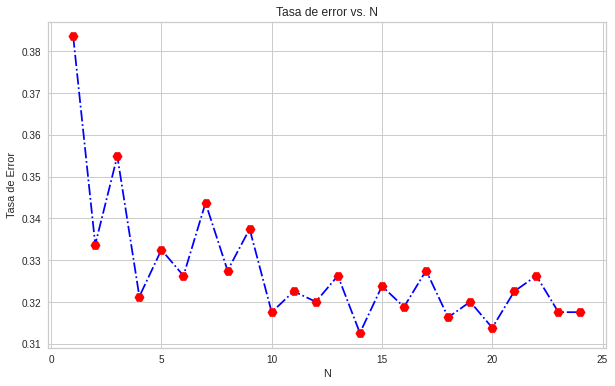

In [33]:
rateError = []
for i in range(1,25):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    rateError.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,25),rateError,color='blue', linestyle='dashdot', marker="H",
         markerfacecolor='red', markersize=10)
plt.title('Tasa de error vs. N')
plt.xlabel('N')
plt.ylabel('Tasa de Error')

Podemos observar que a medida que aumentamos la complejidad (n), el error disminuye considerablemente. Sin embargo, esta tasa de error se basa en la diferencia entre el 100% y el porcentaje de accuracy que obtiene el modelo.

3.1.3. Curva de Aprendizaje

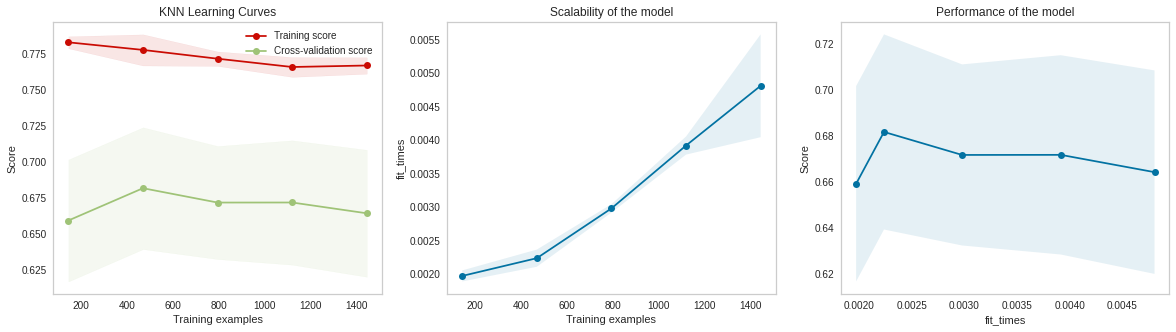

In [34]:
plot_learning_curve(KNeighborsClassifier(n_neighbors=5), "KNN Learning Curves", X, y,cv= kfold)
plt.show()

Gracias a la curva de aprendizaje podemos observar que la curva de entrenamiento y validación no llegan al ajuste adecuado. Es más, el aumentar la cantidad de data para el entrenamiento empeora los del modelo. Aproximadamente el porcentaje de entrenamiento a utilizar es del 30% de la data total.

***Prueba del modelo con los parametros adecuados cálculados***

In [35]:
knnAd = KNeighborsClassifier(n_neighbors=5)
X_trainKnn, X_testKnn, y_trainKnn, y_testKnn = train_test_split(X, y, random_state = 10, train_size = 0.3)
knnAd.fit(X_trainKnn, y_trainKnn)
y_knn_predict = knn.predict(X_testKnn)
print(classification_report(y_testKnn, y_knn_predict))

              precision    recall  f1-score   support

           0       0.72      0.93      0.81       783
           1       0.50      0.16      0.24       341

    accuracy                           0.70      1124
   macro avg       0.61      0.54      0.53      1124
weighted avg       0.65      0.70      0.64      1124



Cambiando la cantidad de n_splits

In [36]:
#@title n_splits = 10
kfoldKnn =KFold(n_splits = 10, random_state = 10)
print("F1 Average: ",cross_val_score(knnAd, X, y, cv= kfoldKnn, scoring = "f1_weighted").mean())

F1 Average:  0.6440128066819242


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [37]:
#@title n_splits = 15
kfoldKnn =KFold(n_splits = 20, random_state = 10)
print("F1 Average: ",cross_val_score(knnAd, X, y, cv= kfoldKnn, scoring = "f1_weighted").mean())

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


F1 Average:  0.6364907720216639


In [38]:
#@title n_splits = 20
kfoldKnn =KFold(n_splits = 25, random_state = 10)
print("F1 Average: ",cross_val_score(knnAd, X, y, cv= kfoldKnn, scoring = "f1_weighted").mean())

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


F1 Average:  0.6330251733830854


La ultima prueba se realizo variando el número de particiones a tomar en cuenta para el entrenamiento. Podemos ver que rendimiento es mayor cuando el valor de n_splits es igual a 10. Sin embargo, la diferencia no es significativa para decir que su influencia es determinante.

### 3.2. Gaussian Naive Bayes

Decidimos usar modelos Naive Bayes para nuestros datos; sin embargo, el primer clasificados ***Gaussian Naive Bayes*** obtuvo un ***accuraccy*** solo del *33.9%* aproximadamente, por lo que descartamos hacer un análisis más exhaustivo del mismo.

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_gnb_predict = gnb.predict(X_test)

print(classification_report(y_test, y_gnb_predict))

kfold = KFold(n_splits = 10, random_state = 10)
print("Accuracy Average  : ", cross_val_score(gnb, X, y, cv=kfold, scoring = "accuracy").mean())
print("F1 Average        : ", cross_val_score(gnb, X, y, cv=kfold, scoring = "f1_weighted").mean())
print("Precision Average : ", cross_val_score(gnb, X, y, cv=kfold, scoring = "precision_weighted").mean())
print("Recall Average    : ", cross_val_score(gnb, X, y, cv=kfold, scoring = "recall_weighted").mean())

              precision    recall  f1-score   support

           0       0.88      0.05      0.09       457
           1       0.29      0.98      0.45       185

    accuracy                           0.32       642
   macro avg       0.59      0.52      0.27       642
weighted avg       0.71      0.32      0.20       642

Accuracy Average  :  0.3633773291925465
F1 Average        :  0.24909296714726725
Precision Average :  0.6803566279748537
Recall Average    :  0.3633773291925465


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


### 3.3. Multinomial Naive Bayes

In [40]:
mnb = MultinomialNB(alpha=1)
mnb.fit(X_train, y_train)

y_mnb_predict = mnb.predict(X_test)

print(classification_report(y_test,y_mnb_predict))

scores_mnb = cross_val_score(mnb, X_train, y_train, cv=15)

kfold = KFold(n_splits = 10, random_state = 10)
print("Accuracy Average  : ", cross_val_score(mnb, X, y, cv=kfold, scoring = "accuracy").mean())
print("F1 Average        : ", cross_val_score(mnb, X, y, cv=kfold, scoring = "f1_weighted").mean())
print("Precision Average : ", cross_val_score(mnb, X, y, cv=kfold, scoring = "precision_weighted").mean())
print("Recall Average    : ", cross_val_score(mnb, X, y, cv=kfold, scoring = "recall_weighted").mean())

              precision    recall  f1-score   support

           0       0.72      0.98      0.83       457
           1       0.50      0.06      0.11       185

    accuracy                           0.71       642
   macro avg       0.61      0.52      0.47       642
weighted avg       0.66      0.71      0.62       642

Accuracy Average  :  0.70340450310559
F1 Average        :  0.5958856481406717
Precision Average :  0.6988128997311245
Recall Average    :  0.70340450310559


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3.3.1 Gráfica de Validación

En el siguiente gráfico de valor ***alpha vs F1-Score***, se puede evidenciar que el mejor parámetro alpha para el model se encuentra entre `[0-2]`, debido que es en donde alcanza una *mejor métrica*. Debido a que 1 es el parámetro predeterminado del modelo, nos inclinaremos por dejar su valor inicial.

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


Text(0, 0.5, 'F1-Score')

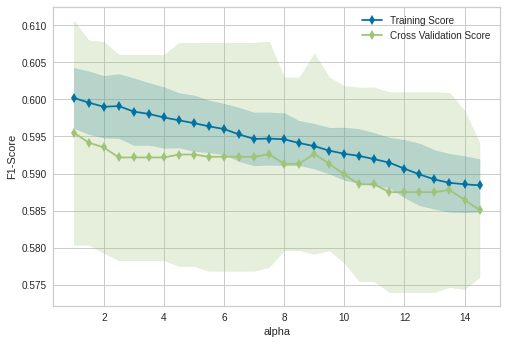

In [41]:
param_range = np.arange(1, 15, 0.5)

mnbVC = ValidationCurve(
    MultinomialNB(), param_name="alpha",
    param_range=param_range, cv=15, scoring="f1_weighted", n_jobs=4,
)

mnbVC.fit(X, y)
plt.legend(loc='best')
plt.xlabel('alpha')
plt.ylabel('F1-Score')

3.3.2 Gráfica de Error

En la siguiente gráfica, podemos visualizar cómo varía el ***error*** del model con respecto a la variación del parámetro alpha.

Text(0, 0.5, 'Error Rate')

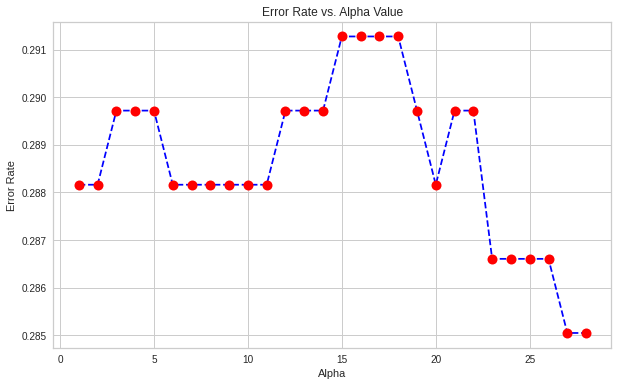

In [42]:
param_range = np.arange(1, 15, 0.5)
error_rate = []

for i in param_range:

    mnb = MultinomialNB(alpha=i)
    mnb.fit(X_train, y_train)

    pred_i = mnb.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,29), error_rate, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)

plt.title('Error Rate vs. Alpha Value')
plt.xlabel('Alpha')
plt.ylabel('Error Rate')

3.3.3 Curva de Aprendizaje

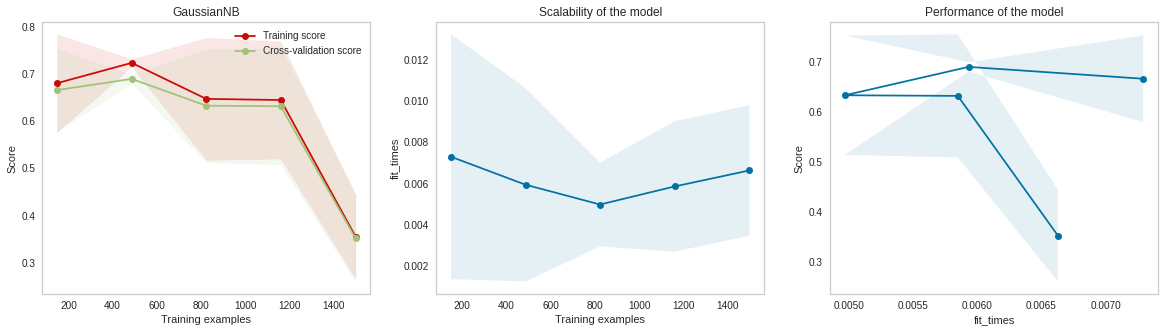

In [43]:
plot_learning_curve(gnb, "GaussianNB", X, y, cv=15, n_jobs=5);

### 3.4. RandomForestClassifier

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10,train_size = 0.3)
clf = RandomForestClassifier(max_depth=3, random_state=10)
clf.fit(X_train, y_train)
y_clf_predict = clf.predict(X_test)
print(classification_report(y_test, y_clf_predict))
print("Accuracy Test: ",accuracy_score(y_test, y_clf_predict))

              precision    recall  f1-score   support

           0       0.71      0.97      0.82       783
           1       0.56      0.09      0.15       341

    accuracy                           0.70      1124
   macro avg       0.63      0.53      0.49      1124
weighted avg       0.66      0.70      0.62      1124

Accuracy Test:  0.7019572953736655


In [45]:
kfold = KFold(n_splits = 10, random_state = 10)
print("Accuracy Average  : ", cross_val_score(clf, X, y, cv=kfold, scoring = "accuracy").mean())
print("F1 Average        : ",cross_val_score(clf, X, y, cv=kfold, scoring = "f1_weighted").mean())
print("Precision Average : ",cross_val_score(clf, X, y, cv=kfold, scoring = "precision_weighted").mean())
print("Recall Average    : ",cross_val_score(clf, X, y, cv=kfold, scoring = "recall_weighted").mean())

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Accuracy Average  :  0.7183773291925466
F1 Average        :  0.641153252831835
Precision Average :  0.7250816187845113
Recall Average    :  0.7183773291925466


3.4.1. Grafica de validación

En este caso se realiza una variación en el parametro **max_depth** que nos indica la máxima profundidad del árbol

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


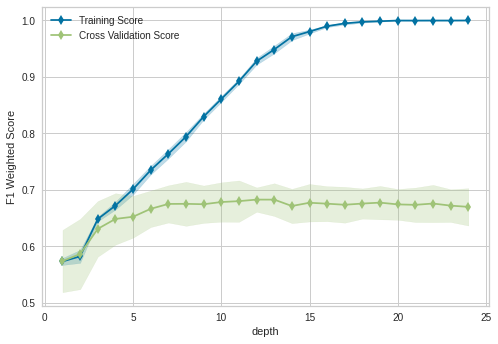

In [46]:
param_range = np.arange(0, 25, 1)
clfVcF1w = ValidationCurve(
    RandomForestClassifier(), param_name="max_depth",
    param_range=param_range, cv=kfold, scoring="f1_weighted", n_jobs=4,
)
clfVcF1w.fit(X, y)
plt.legend(loc='best')
plt.xlabel('depth')
plt.ylabel('F1 Weighted Score')
plt.show()

Como podemos observar, aumentar la profundidad no conlleva a mejores resultado. Es por ello que se elige el valor de 6 ya que la diferencia existente no estan relevante como para aumentar la complejidad.

3.4.2. Tasa de Error

Esta gráfica muestra el error calculado respecto a la variación del valor de **max_depth**

Text(0, 0.5, 'Tasa de Error')

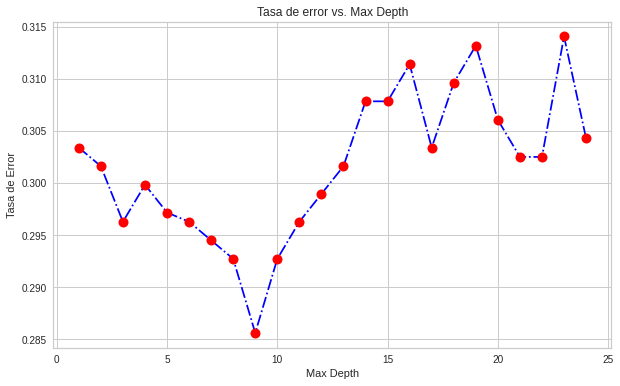

In [47]:
def RateErrorVectorRandomF(X_train,y_train,X_test,y_test):
    rateError = []
    for i in range(1,25):
      clf = RandomForestClassifier(max_depth = i)
      clf.fit(X_train,y_train)
      pred_i = clf.predict(X_test)
      rateError.append(np.mean(pred_i != y_test))
    return rateError

rateErrorRF = RateErrorVectorRandomF(X_train,y_train,X_test,y_test)
plt.figure(figsize=(10,6))
plt.plot(range(1,25),rateErrorRF,color='blue', linestyle='dashdot', marker="o",
         markerfacecolor='red', markersize=10)
plt.title('Tasa de error vs. Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Tasa de Error')

En las diversas prubas que realizamos, la tasa de error aumenta conforme aumentamos la profundidad. En en lo valores más bajos donde la diferencia entre tasas de error es mínima. No es conveniente aumentar la profundidad del arbol.

3.4.3. Curva de Aprendizaje

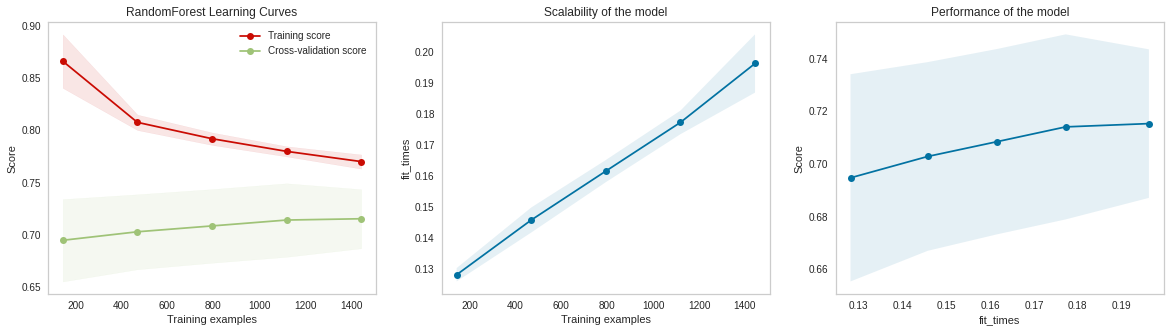

In [48]:
plot_learning_curve(RandomForestClassifier(max_depth = 6), "RandomForest Learning Curves", X, y,cv= kfold)
plt.show()

A partir de la curva podemos observar que la curva de entrenamiento y validación parecen ajustarse cuanto mayor es la data de entrenamiento. Sin embargo, llegar a casi la misma cantidad de entrenamiento que data original puede llegar a ser contraproducente y causar **overfitting**. El mejor porcentaje de entrenamiento a utilizar es del 50% de la data total.

***Prueba del modelo con los parametros adecuados cálculados***

In [49]:
clfAd = RandomForestClassifier(max_depth = 6)
X_trainclfAd, X_testclfAd, y_trainclfAd, y_testclfAd = train_test_split(X, y, random_state = 10, train_size = 0.5)
clfAd.fit(X_trainclfAd, y_trainclfAd)
y_clf_predict = clfAd.predict(X_testclfAd)
print(classification_report(y_testclfAd, y_clf_predict))

              precision    recall  f1-score   support

           0       0.71      0.95      0.81       550
           1       0.56      0.15      0.23       253

    accuracy                           0.69       803
   macro avg       0.63      0.55      0.52       803
weighted avg       0.66      0.69      0.63       803



In [50]:
#@title n_splits = 10
kfoldclf=KFold(n_splits = 10, random_state = 10)
print("F1 Average: ",cross_val_score(clfAd, X, y, cv= kfoldclf, scoring = "f1_weighted").mean())

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


F1 Average:  0.6709149438300446


In [51]:
#@title n_splits = 15
kfoldclf=KFold(n_splits = 10, random_state = 10)
print("F1 Average: ",cross_val_score(clfAd, X, y, cv= kfoldclf, scoring = "f1_weighted").mean())

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


F1 Average:  0.662415734408093


In [52]:
#@title n_splits = 20
kfoldclf=KFold(n_splits = 10, random_state = 10)
print("F1 Average: ",cross_val_score(clfAd, X, y, cv= kfoldclf, scoring = "f1_weighted").mean())

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


F1 Average:  0.6672409750296339


La ultima prueba se realizo variando el número de particiones a tomar en cuenta para el entrenamiento. En las diversas pruebas realizadas el rendimiento es mayor cuando el valor de n_splits es igual a 10. Sin embargo, la diferencia no es significativa para decir que su influencia es determinante.

###3.5. LSTM


Epoch 1/20
5/5 [==============================] - 1s 131ms/step - loss: 0.2537 - val_loss: 0.2129
Epoch 2/20
5/5 [==============================] - 0s 48ms/step - loss: 0.2123 - val_loss: 0.2112
Epoch 3/20
5/5 [==============================] - 0s 50ms/step - loss: 0.2123 - val_loss: 0.2115
Epoch 4/20
5/5 [==============================] - 0s 51ms/step - loss: 0.2114 - val_loss: 0.2115
Epoch 5/20
5/5 [==============================] - 0s 49ms/step - loss: 0.2117 - val_loss: 0.2117
Epoch 6/20
5/5 [==============================] - 0s 49ms/step - loss: 0.2122 - val_loss: 0.2119
Epoch 7/20
5/5 [==============================] - 0s 47ms/step - loss: 0.2119 - val_loss: 0.2141
Epoch 8/20
5/5 [==============================] - 0s 50ms/step - loss: 0.2114 - val_loss: 0.2125
Epoch 9/20
5/5 [==============================] - 0s 48ms/step - loss: 0.2110 - val_loss: 0.2132
Epoch 10/20
5/5 [==============================] - 0s 47ms/step - loss: 0.2104 - val_loss: 0.2135
Epoch 11/20
5/5 [===========

(Text(0.5, 0, 'epoch'), Text(0, 0.5, 'loss'))

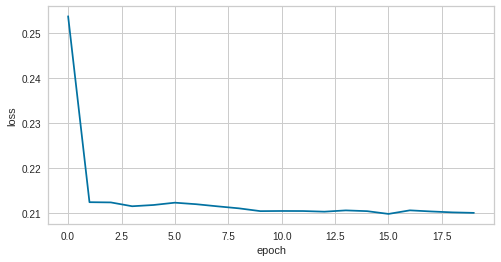

In [53]:
scaler = MinMaxScaler(feature_range=(0, 1))

X_train = np.array(X_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

modelo = Sequential()

modelo.add(LSTM(units = 150,
               input_shape=(X_train.shape[1],1),
               return_sequences=False))

modelo.add(Dense(units =1))
modelo.compile(optimizer='adam', loss='mse')
history = modelo.fit(X_train,y_train,epochs=20,batch_size=100,validation_split = 0.1)


X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


train_prediccion = modelo.predict(X_train)
test_prediccion = modelo.predict(X_test)

plt.figure(figsize = (8,4))
plt.plot(history.history['loss'])
plt.xlabel('epoch'), plt.ylabel('loss')


In [54]:
print(classification_report(y_test, test_prediccion.round()))

              precision    recall  f1-score   support

           0       0.70      1.00      0.82       783
           1       0.00      0.00      0.00       341

    accuracy                           0.70      1124
   macro avg       0.35      0.50      0.41      1124
weighted avg       0.49      0.70      0.57      1124



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


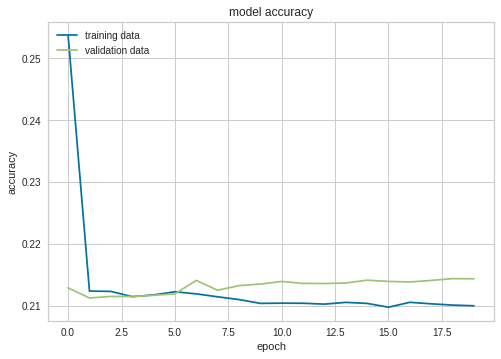

In [55]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training data', 'validation data'], loc='upper left')
plt.show()

# Conclusiones

*   Se usó ***One hot Encoding*** debido a que el ***Labeling Encoding*** presupone que a mayor valor categórico se le otorga a la categoría, esta es mejor. El más claro ejemplo en nuestro caso es con la columna **person_degree_type**, la cual contenía 5 posibles atributos: Carrera Técnica, Postgrado, Primaria, Secundaria y Universitaria. Si usábamos Labeling encoding para esta columna, el modelo de entrenamiento podría haber deducido que Universitara > Secundaria > Primaria > Postgrado > Carrera Técnica. Esto traería consigo un cúmulo de errores a la hora de someter el modelo a entrenamiento.

*   El uso de Machine Learning dentro de una entidad bancaria es bastante reservada, pues no se aplica en todas la áreas. Por ejemplo, la clasificación de billetes falsos realizada con ML es muy delicada. Si esta clasificación se basa en probabilidades, siempre es posible que un billete verdadero sea clasificado como falso y uno falso sea considerado verdadero. Es por ello que su aplicación se da en areas de seguridad (reconocimiento de usuario) y mejorar los servicios y productos para los clientes.
